# US Treasury Yield Curve — Nelson–Siegel Fit
This notebook loads Treasury bond data, computes bond yields to maturity, fits a Nelson–Siegel yield curve, and visualizes the fitted curve alongside observed yields.

In [11]:
import numpy as np 
import pandas as pd 
from scipy.optimize import newton, minimize 
import matplotlib.pyplot as plt

## 1. Import  & Process Data

We take the bond price as the midpoint of the quoted bid and ask to reduce spread bias and stabilize YTM estimation.

$$\text{Price} = \frac{\text{Bid Price} + \text{Ask Price}}{2}$$

This “mid price” is a standard proxy for fair value when quotes include a bid–ask spread.

In [12]:
treasury_bonds = pd.read_excel("US_Treasury_Data.xlsx", sheet_name="Bonds") 
treasury_bonds['Issue Date'] = pd.to_datetime(treasury_bonds['Issue Date']) 
treasury_bonds['Maturity'] = pd.to_datetime(treasury_bonds['Maturity']) 
treasury_bonds["Price"] = (treasury_bonds["Bid Price"] + treasury_bonds["Ask Price"]) / 2
treasury_bonds.head() 

,Issuer Name,Issue Date,Maturity,Bid Price,Ask Price,Cpn,Currency,Price
0,United States Treasury Note/Bond,2018-02-28,2025-02-28,99.980469,100.007812,2.750,USD,99.994141
1,United States Treasury Note/Bond,2023-02-28,2025-02-28,99.984375,100.019531,4.625,USD,100.001953
2,United States Treasury Note/Bond,2020-03-02,2025-02-28,99.945312,100.011719,1.125,USD,99.978516
3,United States Treasury Note/Bond,2022-03-15,2025-03-15,99.859375,99.914062,1.750,USD,99.886719
4,United States Treasury Note/Bond,2020-03-31,2025-03-31,99.621094,99.703125,0.500,USD,99.662109


## 2. Build YTM Solver
Yield-to-maturity is solved per bond using Newton's method on the pricing equation.

Let \(f\) be the coupon frequency and \(FV\) the face value. Define the per-period coupon and number of payments:
$$
c \;=\; \frac{\text{coupon rate}}{100}\cdot\frac{FV}{f}
\quad\text{and}\quad
n \;=\; f \cdot T
$$
where \(T\) is time to maturity in years.

The clean price is the present value of coupons and principal:
$$
P \;=\; \sum_{t=1}^{n} \frac{c}{\left(1 + \frac{y}{f}\right)^t}
\;+\;
\frac{FV}{\left(1 + \frac{y}{f}\right)^n}
$$

In [13]:
def compute_ytm(price, coupon_rate, maturity_years, freq=2, FV=100): 
    """ 
    Computes yield-to-maturity using Newton's method. 
    
    price : clean price (no AI) 
    coupon_rate : annual coupon % (e.g. 3.5 for 3.5%) 
    maturity_years : time to maturity in years 
    freq : number of coupon payments per year (Treasury = 2) 
    """ 
    c = (coupon_rate / 100) * FV / freq 
    n = int(maturity_years * freq) 

    def price_from_yield(y): 
        pv_coupons = sum(c / (1 + y/freq)**t for t in range(1, n+1)) 
        pv_face = FV / (1 + y/freq)**n 
        return pv_coupons + pv_face 

    f = lambda y: price_from_yield(y) - price 
    try:
        return newton(f, x0=0.03, maxiter=100)
    except:
        return np.nan


## 3. Time to Maturity
Compute time to maturity in years and filter out expired bonds.

Let $t_{0}$ be the valuation date and $M$ the bond’s maturity date. Using an ACT/365 convention:

$$
T \;=\; \frac{\text{days}\!\left(M - t_{0}\right)}{365}
$$

In [14]:
today = pd.Timestamp.today() 

treasury_bonds["Tau"] = (treasury_bonds["Maturity"] - today).dt.days / 365 
treasury_bonds = treasury_bonds[treasury_bonds["Tau"] > 0] 
treasury_bonds.head() 

,Issuer Name,Issue Date,Maturity,Bid Price,Ask Price,Cpn,Currency,Price,Tau
40,United States Treasury Note/Bond,2018-11-30,2025-11-30,98.960938,99.000000,2.875,USD,98.980469,0.041096
41,United States Treasury Note/Bond,2020-11-30,2025-11-30,97.097656,97.156250,0.375,USD,97.126953,0.041096
42,United States Treasury Note/Bond,2023-11-30,2025-11-30,100.421875,100.457031,4.875,USD,100.439453,0.041096
43,United States Treasury Note/Bond,2022-12-15,2025-12-15,99.808594,99.851562,4.000,USD,99.830078,0.082192
44,United States Treasury Note/Bond,2024-01-02,2025-12-31,100.000000,100.042969,4.250,USD,100.021484,0.126027


## 4. Calculate YTM
Apply the YTM solver across bonds and drop missing yields.

In [15]:
ytms = [] 
for _, row in treasury_bonds.iterrows(): 
    ytm = compute_ytm( 
        price=row["Price"], 
        coupon_rate=row["Cpn"], 
        maturity_years=row["Tau"], 
        freq=2 
    ) 
    ytms.append(ytm) 

treasury_bonds["YTM"] = ytms 
treasury_bonds = treasury_bonds.dropna(subset=["YTM"]) 
treasury_bonds.head() 

,Issuer Name,Issue Date,Maturity,Bid Price,Ask Price,Cpn,Currency,Price,Tau,YTM
67,United States Treasury Note/Bond,2019-05-31,2026-05-31,97.468750,97.500000,2.125,USD,97.484375,0.539726,0.073409
68,United States Treasury Note/Bond,2024-05-31,2026-05-31,100.804688,100.828125,4.875,USD,100.816406,0.539726,0.032159
69,United States Treasury Note/Bond,2021-06-01,2026-05-31,95.804688,95.835938,0.750,USD,95.820312,0.539726,0.095067
70,United States Treasury Note/Bond,2023-06-15,2026-06-15,99.921875,99.941406,4.125,USD,99.931641,0.580822,0.042646
71,United States Treasury Note/Bond,2021-06-30,2026-06-30,95.703125,95.734375,0.875,USD,95.718750,0.621918,0.098596


## 5. Nelson–Siegel Model
Let $t_{0}$ be the valuation date and $M$ the bond’s maturity date. Using an ACT/365 convention:
$$
T = \frac{\text{days}!\left(M - t_{0}\right)}{365}
$$

Under the Nelson–Siegel model, the zero-coupon yield for maturity $T$ is:
$$
y(T) = \beta_{0}+ \beta_{1}!\left(\frac{1 - e^{-\lambda T}}{\lambda T}\right)
+ \beta_{2}!\left(\frac{1 - e^{-\lambda T}}{\lambda T} - e^{-\lambda T}\right)
$$

- $\beta_{0}$: long-term level
- $\beta_{1}$: slope
- $\beta_{2}$: curvature
- $\lambda$: decay parameter

In [16]:
def nelson_siegel(tau, beta0, beta1, beta2, lamb): 
    """ 
    NS yield curve function y(t). 
    """ 
    term1 = (1 - np.exp(-lamb * tau)) / (lamb * tau) 
    term2 = term1 - np.exp(-lamb * tau) 
    return beta0 + beta1 * term1 + beta2 * term2 

def ns_objective(params, tau, ytm_obs): 
    beta0, beta1, beta2, lamb = params 
    ytm_pred = nelson_siegel(tau, beta0, beta1, beta2, lamb) 
    return np.sum((ytm_obs - ytm_pred)**2) 


## 6. Fit NS Parameters
Estimate parameters by minimizing SSE between observed YTMs and the model.

In [17]:
tau_data = treasury_bonds["Tau"].values 
ytm_data = treasury_bonds["YTM"].values 

initial_guess = [0.05, -0.02, 0.01, 0.5] 

result = minimize(ns_objective, initial_guess, args=(tau_data, ytm_data)) 

beta0, beta1, beta2, lamb = result.x 

print(f"Level (β0):   {beta0}") 
print(f"Slope (β1):   {beta1}") 
print(f"Curvature (β2): {beta2}") 
print(f"Decay (λ):     {lamb}")

Level (β0):   0.04890270266038923
Slope (β1):   0.033836531837712555
Curvature (β2): -0.05874301748185705
Decay (λ):     0.7524474530424526


## 7. Goodness Of Fit

In [18]:
ytm_pred = nelson_siegel(tau_data, beta0, beta1, beta2, lamb)
residuals = ytm_data - ytm_pred

SSE = np.sum(residuals**2)
MSE = SSE / len(ytm_data)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(residuals))

print(f"SSE  (Sum of Squared Errors): {SSE:.6f}")
print(f"RMSE (Root Mean Squared Error): {RMSE:.6f}")
print(f"MAE  (Mean Absolute Error): {MAE:.6f}")


SSE  (Sum of Squared Errors): 0.043756
RMSE (Root Mean Squared Error): 0.012501
MAE  (Mean Absolute Error): 0.006490


## 8. Plot Fitted Yield Curve
Visualize the fitted curve against the observed bond YTMs.

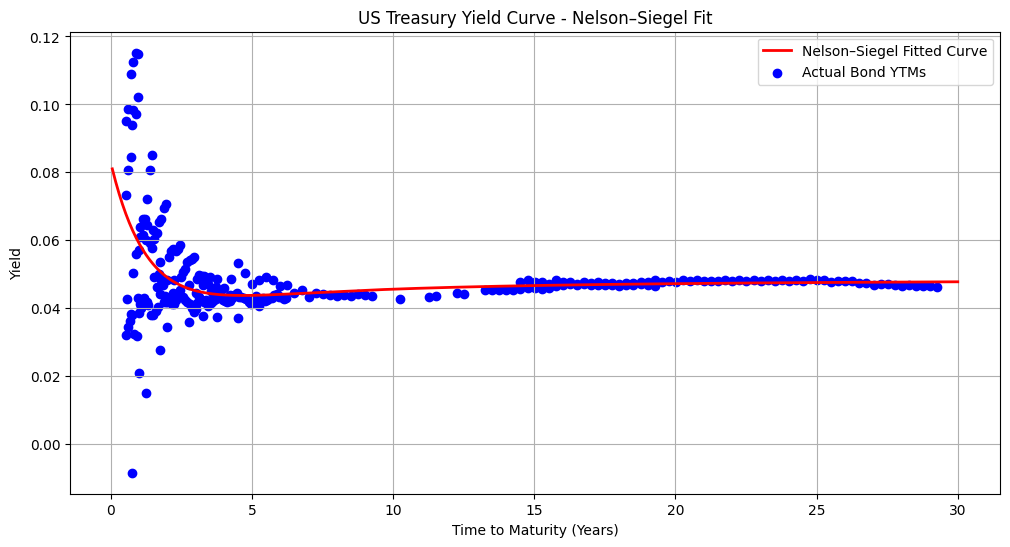

In [19]:
tau_grid = np.linspace(0.05, 30, 500) 
fitted_curve = nelson_siegel(tau_grid, beta0, beta1, beta2, lamb) 

plt.figure(figsize=(12, 6)) 
plt.plot(tau_grid, fitted_curve, color = "red", label="Nelson–Siegel Fitted Curve", linewidth=2) 
plt.scatter(tau_data, ytm_data, color='blue', label="Actual Bond YTMs") 
plt.title("US Treasury Yield Curve - Nelson–Siegel Fit") 
plt.xlabel("Time to Maturity (Years)") 
plt.ylabel("Yield") 
plt.grid(True) 
plt.legend() 
plt.show() 


# Yield Curve Analysis 
This analysis estimates the U.S. Treasury yield curve using the Nelson–Siegel (NS) model. Yields were derived from mid-prices across a wide range of maturities (0.3 to 30 years) and used as inputs for curve fitting.


## Model Fit Quality

The model was calibrated by minimizing the error between observed and NS-implied yields.

**Goodness of Fit**

* **RMSE:** 0.0125 (≈1.25 bps)
* **MAE:** 0.00649 (≈0.65 bps)
* **SSE:** 0.0438

These values indicate an excellent fit, with errors well below 2 basis points.
R² is intentionally excluded, as it is not meaningful for yield curve modeling due to the low variance of yields.

---

## Interpretation of Nelson–Siegel Parameters

| Parameter          | Value   | Interpretation                              |
| ------------------ | ------- | ------------------------------------------- |
| **β₀ (Level)**     | 0.0489  | Long-term yield (~4.9%)                     |
| **β₁ (Slope)**     | 0.0338  | Short-end steepness                         |
| **β₂ (Curvature)** | -0.0587 | Slight downward curvature in mid-maturities |
| **λ (Decay)**      | 0.7524  | Curvature peak at approximately 1.3 years   |

#### What These Values Mean for the Market

The upward-sloping curve suggests reduced immediate recession risk and expectations of a soft-landing scenario.

Medium-term softness (negative β₂) signals that markets anticipate slower growth or moderate policy easing over the next few years.

A relatively high β₀ indicates investors believe interest rates will stabilize at higher long-term levels, aligning with the “higher for longer” narrative.

Overall, the curve reflects a market that expects gradual normalization: no sharp cuts, no deep recession, but moderate long-term rates supported by stable inflation expectations.

---

## Why Nelson–Siegel?

* Produces smooth and realistic term structures
* Parameters have clear economic meaning (level, slope, curvature)
* Stable and robust for large Treasury datasets
* Widely used by central banks and macro-finance research

The Nelson–Siegel model offers an effective balance between flexibility, interpretability, and stability, making it a strong choice for Treasury yield curve estimation.


| Parameter          | Low Range     | High Range    | What It Indicates                                                                                                                              |
| ------------------ | ------------- | ------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **β₀ (Level)**     | **0% – 2%**   | **4% – 6%+**  | **Low:**<br>• Low long-term rates<br>• Weak inflation outlook<br>**High:**<br>• Elevated long-term rates<br>• “Higher for longer” expectations |
| **β₁ (Slope)**     | **≤ 0%**      | **≥ 2%**      | **Low/Negative:**<br>• Recession risk<br>• Expected rate cuts<br>**High:**<br>• Steep upward slope<br>• Stronger growth expectations           |
| **β₂ (Curvature)** | **≤ –0.02**   | **≥ +0.02**   | **Negative:**<br>• Medium-term dip<br>• Slower growth expected<br>**Positive:**<br>• Hump shape<br>• Near-term volatility or tightening        |
| **λ (Decay)**      | **0.1 – 0.4** | **1.0 – 2.0** | **Low λ:**<br>• Curve shape driven by long maturities<br>**High λ:**<br>• Curve shape driven by short maturities                               |
